In [14]:
# https://www.statmt.org/europarl/

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Input, Bidirectional, RepeatVector, MultiHeadAttention, Dense, Layer, LayerNormalization, TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import string
import re
import sentencepiece as spm
from pathlib import Path


tf.random.set_seed(34)

In [15]:
# dataset = pd.read_csv("eng-hin-dataset.csv")
dataset = pd.read_csv("./data.csv")
dataset.drop_duplicates(inplace=True)

print("Dataset shape:", dataset.shape)
dataset.head()

Dataset shape: (118964, 2)


,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [16]:
dataset["english"] = dataset["english"].str.lower()
dataset["spanish"] = dataset["spanish"].str.lower()

dataset.sort_index()
dataset.head()

,english,spanish
0,go.,ve.
1,go.,vete.
2,go.,vaya.
3,go.,váyase.
4,hi.,hola.


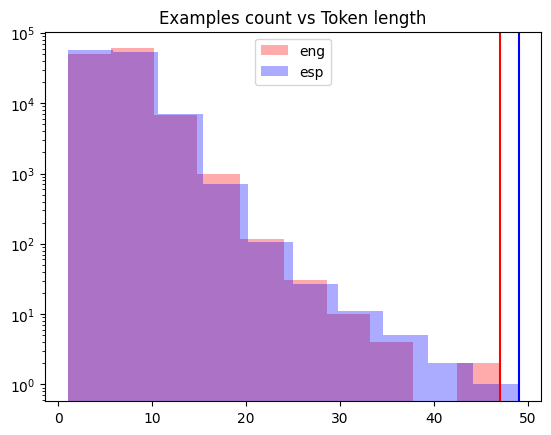

In [7]:
import matplotlib.pyplot as plt

# histogram of sentence length in tokens
eng_length = [len(sentence.split()) for sentence in dataset["english"]]
esp_length = [len(sentence.split()) for sentence in dataset["spanish"]]

plt.hist(eng_length, label="eng", color="red", alpha=0.33)
plt.hist(esp_length, label="esp", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(eng_length), max(eng_length)], plt.ylim(), color="red")
plt.plot([max(esp_length), max(esp_length)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [8]:
max_eng = max(eng_length)
max_esp = max(esp_length)
max_eng, max_esp

(47, 49)

In [62]:
# Write clean text lists to disk for SP training
Path("sp_data").mkdir(exist_ok=True)
eng_path = "sp_data/eng.txt"
esp_path = "sp_data/esp.txt"

with open(eng_path, "w") as f:
    for line in dataset['english'].dropna():
        f.write(line.replace('"', '').lower() + "\n")

with open(esp_path, "w") as f:
    for line in dataset['spanish'].dropna():
        f.write(line.lower() + "\n")

In [63]:
# Train EN BPE
# spm.SentencePieceTrainer.Train(
#     input=en_path,
#     model_prefix="bpe_eng",
#     vocab_size=20000,              
#     model_type="bpe",
#     character_coverage=1.0,        
#     pad_id=0, unk_id=1, bos_id=2, eos_id=3
# )

# Train HI BPE
# spm.SentencePieceTrainer.Train(
#     input=hi_path,
#     model_prefix="bpe_esp",
#     vocab_size=20000,              
#     model_type="bpe",
#     character_coverage=1.0,    
#     pad_id=0, unk_id=1, bos_id=2, eos_id=3
# )

spm.SentencePieceTrainer.Train(
    input=[eng_path, esp_path],
    model_prefix="bpe_mixed",
    vocab_size=32000,              
    model_type="bpe",
    character_coverage=0.9995,    
    pad_id=0, unk_id=1, bos_id=2, eos_id=3
)

print("BPE trained")

BPE trained


In [12]:
# Load the trained BPE models
eng_sp = spm.SentencePieceProcessor()
eng_sp.load('./bpe_mixed.model')

esp_sp = spm.SentencePieceProcessor()
esp_sp.load('bpe_mixed.model')

# Create tokenization functions
def encode_eng(text):
    return eng_sp.encode(text, add_bos=False, add_eos=False), eng_sp.encode_as_pieces(text, add_bos=False, add_eos=False)

def encode_esp(text):
    return esp_sp.encode(text, add_bos=True, add_eos=True), esp_sp.encode_as_pieces(text, add_bos=True, add_eos=True)

def decode_esp(tokens):
    return esp_sp.decode(tokens)

# Test the tokenizers
sample_eng = dataset['english'][2400]
sample_esp = dataset['spanish'][2400]

print(f"Original EN: {sample_eng}")
print(f"Tokenized EN: {encode_eng(sample_eng)}")
print(f"Original ESP: {sample_esp}")
print(f"Tokenized ESP: {encode_esp(sample_esp)}")


Original EN: where is he?
Tokenized EN: ([482, 71, 65, 31982], ['▁where', '▁is', '▁he', '?'])
Original ESP: ¿dónde está él?
Tokenized ESP: ([2, 70, 964, 154, 129, 31982, 3], ['<s>', '▁¿', 'dónde', '▁está', '▁él', '?', '</s>'])


In [9]:
MAX_LENGTH = 128 

# Load the trained BPE models
eng_sp = spm.SentencePieceProcessor()
eng_sp.load('/kaggle/input/bpe-mixed/other/default/1/bpe_mixed.model')

esp_sp = spm.SentencePieceProcessor()
esp_sp.load('/kaggle/input/bpe-mixed/other/default/1/bpe_mixed.model')

def tokenize_data(df):
    # Apply your encoding functions
    en_tokenized = df['english'].dropna().apply(lambda x: eng_sp.encode(str(x), add_bos=False, add_eos=False))
    hi_tokenized = df['spanish'].dropna().apply(lambda x: esp_sp.encode(str(x), add_bos=True, add_eos=True))

    # Filter out sentences that are too long
    filtered_eng, filtered_esp = [], []
    for eng, esp in zip(en_tokenized, hi_tokenized):
        if len(eng) <= MAX_LENGTH and len(esp) <= MAX_LENGTH + 1:
            filtered_eng.append(eng)
            filtered_esp.append(esp)
            
    return filtered_eng, filtered_esp

In [10]:
train_df, valid_df = train_test_split(dataset, test_size=0.2, random_state=42)
train_df.shape, valid_df.shape

((95171, 2), (23793, 2))

In [11]:
# Tokenize the training and validation dataframes
eng_train_tokens, esp_train_tokens = tokenize_data(train_df)
eng_valid_tokens, esp_valid_tokens = tokenize_data(valid_df)

In [9]:
BUCKETS = [10, 20, 30, 60] 

def create_buckets(buckets, src, trg):
    src_bucket = {}
    trg_bucket = {}

    for bucket in buckets:
        src_bucket[bucket] = []
        trg_bucket[bucket] = []

    for i in range(len(src)):
        src_len = len(src[i])
        trg_len = len(trg[i])

        if(trg_len > 2*src_len or src_len > 2*trg_len):
            continue

        for bucket in buckets:
            final_size = max(src_len, trg_len)
            if(final_size < bucket):
                src_bucket[bucket].append(src[i])
                trg_bucket[bucket].append(trg[i])
                break

    print("Bucket Results:")
    for bucket in buckets:
        print(f"Bucket {bucket}: {len(src_bucket[bucket])} pairs")
    print("Total Pairs: ", sum([len(src_bucket[bucket]) for bucket in buckets]))
    
    return src_bucket, trg_bucket

In [10]:
train_buckets_eng, train_buckets_esp = create_buckets(BUCKETS, eng_train_tokens, esp_train_tokens)
val_buckets_eng, val_buckets_esp = create_buckets(BUCKETS, eng_valid_tokens, esp_valid_tokens)

Bucket Results:
Bucket 10: 52412 pairs
Bucket 20: 41359 pairs
Bucket 30: 804 pairs
Bucket 60: 55 pairs
Total Pairs:  94630
Bucket Results:
Bucket 10: 13163 pairs
Bucket 20: 10266 pairs
Bucket 30: 208 pairs
Bucket 60: 16 pairs
Total Pairs:  23653


In [11]:
def analyze(bucket_src, bucket_tgt):
    # Calculate lengths for source and target training tokens
    src_lengths = [len(seq) for seq in bucket_src]
    tgt_lengths = [len(seq) for seq in bucket_tgt]

    # Compute statistics for source
    src_mean = sum(src_lengths) / len(src_lengths)
    src_min = min(src_lengths)
    src_max = max(src_lengths)

    # Compute statistics for target
    tgt_mean = sum(tgt_lengths) / len(tgt_lengths)
    tgt_min = min(tgt_lengths)
    tgt_max = max(tgt_lengths)
    
    print(f"Source train tokens - Mean: {src_mean:.2f}, Min: {src_min}, Max: {src_max}")
    print(f"Target train tokens - Mean: {tgt_mean:.2f}, Min: {tgt_min}, Max: {tgt_max}")
    print("")


In [12]:
for val in BUCKETS:
    analyze(train_buckets_eng[val], train_buckets_esp[val])

Source train tokens - Mean: 6.29, Min: 2, Max: 9
Target train tokens - Mean: 7.52, Min: 4, Max: 9

Source train tokens - Mean: 10.08, Min: 5, Max: 19
Target train tokens - Mean: 11.65, Min: 6, Max: 19

Source train tokens - Mean: 19.34, Min: 11, Max: 29
Target train tokens - Mean: 21.42, Min: 13, Max: 29

Source train tokens - Mean: 30.25, Min: 21, Max: 51
Target train tokens - Mean: 33.98, Min: 26, Max: 52



In [13]:
def preprocess(inp, out):
    return ({"encoder_inputs": inp, "decoder_inputs": out[:, :-1]}, out[:, 1:])
    
def make_dataset_for_one_bucket(inp_tokens, out_tokens, batch_size, mode="train"):
    """
    Takes the token lists for a SINGLE bucket and turns them into a padded,
    batched, and prefetched tf.data.Dataset.
    """
    # Pad all sequences in this bucket to the bucket's max length
    # Using max length of the bucket, not the global MAX_LENGTH, is more efficient
    max_len_in_inp = max(len(seq) for seq in inp_tokens)
    max_len_in_out = max(len(seq) for seq in out_tokens)
    
    inp_padded = pad_sequences(inp_tokens, maxlen=max_len_in_inp, padding="post")
    out_padded = pad_sequences(out_tokens, maxlen=max_len_in_out, padding="post")

    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((inp_padded, out_padded))
    
    # Shuffle is crucial for training
    if mode == "train":
       # Shuffle the individual examples within the bucket
       dataset = dataset.shuffle(buffer_size=len(inp_tokens)) 
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # We will prefetch the final combined dataset, not the individual ones.
    return dataset

def create_final_dataset_from_buckets(src_bucket_dict, trg_bucket_dict, buckets, batch_size, mode="train"):
    """
    Combines manually created buckets into a single, efficient, sampled dataset.
    """
    list_of_datasets = []
    num_samples_in_buckets = [] # To store the size of each bucket for weighting

    print("\n--- Creating a tf.data.Dataset for each bucket ---")
    for bucket_size in buckets:
        src_tokens = src_bucket_dict[bucket_size]
        trg_tokens = trg_bucket_dict[bucket_size]

        if src_tokens: # Check if the bucket is not empty
            print(f"Processing bucket {bucket_size} with {len(src_tokens)} pairs...")
            bucket_ds = make_dataset_for_one_bucket(
                src_tokens,
                trg_tokens,
                batch_size,
                mode
            )
            list_of_datasets.append(bucket_ds)
            num_samples_in_buckets.append(len(src_tokens))

    if not list_of_datasets:
        raise ValueError("No data found in any of the buckets. Cannot create a dataset.")

    # --- THE FIX ---
    # Calculate sampling probabilities. This ensures each sample has an equal chance
    # of being selected, regardless of its bucket size.
    total_samples = sum(num_samples_in_buckets)
    sampling_probabilities = [count / total_samples for count in num_samples_in_buckets]
    
    print(f"\n--- Combining {len(list_of_datasets)} buckets into a single dataset ---")
    # Use sample_from_datasets to create a single dataset that pulls from the buckets
    # according to the specified probabilities.
    final_dataset = tf.data.Dataset.sample_from_datasets(
        list_of_datasets,
        weights=sampling_probabilities
    ).prefetch(tf.data.AUTOTUNE) # Add prefetching here for better performance

    print(f"\n✅ Successfully created a single sampled dataset from {len(list_of_datasets)} buckets.")
    
    return final_dataset

In [14]:
train_ds = create_final_dataset_from_buckets(
    train_buckets_eng,
    train_buckets_esp,
    BUCKETS,
    128,
    mode="train"
)

val_ds = create_final_dataset_from_buckets(
    val_buckets_eng,
    val_buckets_esp,
    BUCKETS,
    128,
    mode="val"
)


--- Creating a tf.data.Dataset for each bucket ---
Processing bucket 10 with 52412 pairs...


I0000 00:00:1760197683.537276      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Processing bucket 20 with 41359 pairs...
Processing bucket 30 with 804 pairs...
Processing bucket 60 with 55 pairs...

--- Combining 4 buckets into a single dataset ---

✅ Successfully created a single sampled dataset from 4 buckets.

--- Creating a tf.data.Dataset for each bucket ---
Processing bucket 10 with 13163 pairs...
Processing bucket 20 with 10266 pairs...
Processing bucket 30 with 208 pairs...
Processing bucket 60 with 16 pairs...

--- Combining 4 buckets into a single dataset ---

✅ Successfully created a single sampled dataset from 4 buckets.


In [12]:
# Create a generator function that yields the correct inputs and targets
def data_generator(en_tokens, hi_tokens):
    def gen():
        for en, hi in zip(en_tokens, hi_tokens):
            yield (en, hi[:-1], hi[1:])
    return gen

# Create the raw training dataset from the generator
train_dataset_raw = tf.data.Dataset.from_generator(
    data_generator(eng_train_tokens, esp_train_tokens),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
    )
)

# Create the raw validation dataset from the generator
valid_dataset_raw = tf.data.Dataset.from_generator(
    data_generator(eng_valid_tokens, esp_valid_tokens),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
    )
)

I0000 00:00:1760600781.643325      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
# --- This is the corrected code ---

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# This function tells the bucketing mechanism how to measure the length
def element_length_func(en, hi_in, hi_out):
    return tf.shape(en)[0]

# This formats the output of the dataset to match the model's input names
def format_dataset(en, hi_in, hi_out):
    return ({"encoder_inputs": en, "decoder_inputs": hi_in}, hi_out)

# Define bucket boundaries and the batch size for each bucket
bucket_boundaries = [10, 20, 30, 60]
bucket_batch_sizes = [BATCH_SIZE, BATCH_SIZE, BATCH_SIZE, BATCH_SIZE, BATCH_SIZE]

# Create the final training dataset using the new, stable API
train_ds = train_dataset_raw.shuffle(BUFFER_SIZE).bucket_by_sequence_length(
    element_length_func=element_length_func,
    bucket_boundaries=bucket_boundaries,
    bucket_batch_sizes=bucket_batch_sizes,
    # The padding arguments are still needed to create dense batches
    padding_values=(
        tf.constant(0, dtype=tf.int64), # pad encoder inputs with 0
        tf.constant(0, dtype=tf.int64), # pad decoder inputs with 0
        tf.constant(0, dtype=tf.int64)  # pad decoder targets with 0
    ),
    drop_remainder=True # Ensures all batches have a fixed size
).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Create the final validation dataset (no shuffling)
valid_ds = valid_dataset_raw.bucket_by_sequence_length(
    element_length_func=element_length_func,
    bucket_boundaries=bucket_boundaries,
    bucket_batch_sizes=bucket_batch_sizes,
    padding_values=(
        tf.constant(0, dtype=tf.int64),
        tf.constant(0, dtype=tf.int64),
        tf.constant(0, dtype=tf.int64)
    ),
    drop_remainder=True
).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

print("Data pipelines created successfully using the stable API.")

Data pipelines created successfully using the stable API.


In [17]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.max_len = sequence_length
        self.d_model = embed_dim

        # Compute the angles: [max_len, d_model]
        pos = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]        # [L, 1]
        i = tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :]                # [1, D]
        angle_rates = 1.0 / tf.pow(10000.0, (2.0 * (i // 2)) / embed_dim)       # [1, D]
        angle_rads  = pos * angle_rates                                         # [L, D]

        # Apply sin to even indices; cos to odd indices (no in-place writes)
        sines   = tf.sin(angle_rads[:, 0::2])                              # [L, D/2]
        cosines = tf.cos(angle_rads[:, 1::2])                              # [L, D/2]

        # Interleave even/odd back to [L, D]
        # stack -> [L, D/2, 2]  -> reshape -> [L, D]
        pos_encoding = tf.reshape(
            tf.stack([sines, cosines], axis=-1),
            [sequence_length, embed_dim]
        )
        self.pos_encoding = tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # inputs: [B, T, D]
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[tf.newaxis, :seq_len, :] # broadcasts over batch
        

In [18]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, drop_rate=0.2, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = Sequential(
            [
                Dense(ff_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(drop_rate)
        self.dropout2 = Dropout(drop_rate)

    def call(self, inputs, training=False):
        # Sub layer 1
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Sub layer 2
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [19]:
# Minor fix to prevent a potential "UnboundLocalError" if no mask is passed
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True
        
    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        padding_mask = None # Initialize padding_mask to None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, 
            value=inputs, 
            key=inputs, 
            attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=out_1, 
            value=encoder_outputs, 
            key=encoder_outputs, 
            attention_mask=padding_mask
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        
        proj_output = self.dense_proj(out_2)
        out_3 = self.layernorm_3(out_2 + proj_output)

        return out_3
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [20]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        # Formula: lrate = d_model**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        step = tf.cast(step, tf.float32)
        
        arg1 = tf.math.rsqrt(step) # 1 / sqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
class Config:
    
    ENC_VOCAB_SIZE = 20000  # Vocabulary size for the source language (English)
    DEC_VOCAB_SIZE = 20000  # Vocabulary size for the target language (Hindi)
    MIX_VOCAB_SIZE = 32000

    # --- 3. Model Architecture Configuration ---
    EMBED_DIM = 256             # The dimensionality of the token embeddings.
    FF_DIM = 1024               # A common practice is 4 * EMBED_DIM.
    NUM_HEADS = 8               # Number of attention heads in the MultiHeadAttention layer. Must be a divisor of EMBED_DIM.

    NUM_ENCODER_LAYERS = 4      # Number of TransformerEncoder blocks (not in original code, but a key hyperparameter)
    NUM_DECODER_LAYERS = 4      # Number of TransformerDecoder blocks (not in original code, but a key hyperparameter)
    
    # --- 4. Regularization ---
    DROPOUT_RATE = 0.2          # Dropout rate used in the Transformer blocks.
    
    # --- 5. Data Pipeline and Training Configuration ---
    MAX_LENGTH = 128            # The maximum sequence length for filtering and padding.
    BATCH_SIZE = 64             # The number of sequences in a single batch.
    BUFFER_SIZE = 20000         # The buffer size for shuffling the dataset.
    
    EPOCHS = 150                 # Number of epochs to train the model for.
    
    WARMUP_STEPS = 4000

    IS_TRAINING = False

config = Config()

In [23]:
def get_transformer(config):
    # --- ENCODER ---
    encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
    
    # Embedding layers (no change here)
    encoder_embedding_layer = Embedding(config.MIX_VOCAB_SIZE, config.EMBED_DIM, name="encoder_embedding")
    encoder_pos_embedding_layer = PositionalEmbedding(config.MAX_LENGTH, config.EMBED_DIM, name="encoder_positional_embedding")

    # Initial input processing (no change here)
    x = encoder_embedding_layer(encoder_inputs)
    x = encoder_pos_embedding_layer(x)
    x = Dropout(config.DROPOUT_RATE)(x)

    # --- STACKING THE ENCODERS ---
    # Create N encoder layers and pass the output of one to the next.
    for i in range(config.NUM_ENCODER_LAYERS):
        x = TransformerEncoder(
            embed_dim=config.EMBED_DIM,
            num_heads=config.NUM_HEADS,
            ff_dim=config.FF_DIM,
            drop_rate=config.DROPOUT_RATE,
            name=f"transformer_encoder_layer_{i+1}"
        )(x)
    
    # The final output of the encoder stack
    encoder_outputs = x

    # --- DECODER ---
    decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
    
    # Embedding layers for the decoder (no change here)
    decoder_embedding_layer = Embedding(config.MIX_VOCAB_SIZE, config.EMBED_DIM, name="decoder_embedding")
    decoder_pos_embedding_layer = PositionalEmbedding(config.MAX_LENGTH, config.EMBED_DIM, name="decoder_positional_embedding")

    # Initial input processing for the decoder (no change here)
    x = decoder_embedding_layer(decoder_inputs)
    x = decoder_pos_embedding_layer(x)
    x = Dropout(config.DROPOUT_RATE)(x)

    # --- STACKING THE DECODERS ---
    # Create N decoder layers. Each layer receives the output from the previous
    # decoder layer AND the final output of the encoder stack.
    for i in range(config.NUM_DECODER_LAYERS):
        x = TransformerDecoder(
            embed_dim=config.EMBED_DIM,
            ff_dim=config.FF_DIM,
            num_heads=config.NUM_HEADS,
            name=f"transformer_decoder_layer_{i+1}"
        )(inputs=x, encoder_outputs=encoder_outputs) # Pass both inputs here

    # Final output layers (no change here)
    decoder_outputs = Dense(config.MIX_VOCAB_SIZE, activation="softmax", name="final_probabilities")(x)
    
    # --- ASSEMBLE AND COMPILE THE FINAL MODEL ---
    transformer = Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer_stacked"
    )
    


    transformer.compile(
        optimizer=Adam(
            learning_rate=CustomSchedule(config.EMBED_DIM, config.WARMUP_STEPS),
            beta_1=0.9, 
            beta_2=0.98, 
            epsilon=1e-9
        ),
        # optimizer=Adam(
        #     learning_rate=1e-4, 
        #     beta_1=0.9, 
        #     beta_2=0.98, 
        #     epsilon=1e-9
        # ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"] # Your custom metric can be here
    )
    return transformer


transformer = get_transformer(config)
transformer.summary()
# keras.utils.plot_model(transformer, show_shapes=True)

Model: "transformer_stacked"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │  8,192,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_positional… │ (None, None, 256) │          0 │ encoder_embeddin… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 256) │          0 │ encoder_position… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,630,144 │ dropout[0][0]     │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,630,144 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │  8,192,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,630,144 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_positional… │ (None, None, 256) │          0 │ decoder_embeddin… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,630,144 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, None, 256) │          0 │ decoder_position… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  4,734,208 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  4,734,208 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  4,734,208 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  4,734,208 │ transformer_enco… │
│ (TransformerDecode… │                   │            │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_probabilities │ (None, None,      │  8,224,000 │ transformer_deco… │
│ (Dense)             │ 32000)            │            │                 

 Total params: 54,065,408 (206.24 MB)

 Trainable params: 54,065,408 (206.24 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import math

STEPS_PER_EPOCH = math.ceil(94630 / config.BATCH_SIZE)
VALIDATION_STEPS = math.ceil(23653 / config.BATCH_SIZE)

STEPS_PER_EPOCH, VALIDATION_STEPS

(1479, 370)

In [ ]:
model_name = "./weights/transformer_model_eng_esp-2.weights.h5"

if config.IS_TRAINING:
    # Callback to save the best model during training
    checkpoints = tf.keras.callbacks.ModelCheckpoint(
        model_name,  # Corrected filename extension
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True, 
    )
    
    # Callback for early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        patience=15,
        monitor="val_loss",
        mode="min",
        restore_best_weights=True,
    )


    # Training the model
    print("--- Starting Model Training ---")
    history = transformer.fit(
        train_ds,
        epochs=config.EPOCHS,
        validation_data=valid_ds,
        
        # steps_per_epoch=STEPS_PER_EPOCH,
        # validation_steps=VALIDATION_STEPS,
        callbacks=[checkpoints, early_stop],
    )
    print("\\n--- Model Training Finished ---")
    
    # Load the best weights saved during training
    print("Loading best weights from training...")
    # FIX: Corrected filename to match the checkpoint filename
    transformer.load_weights(model_name)

else:
    # If not training, attempt to load a pre-existing model
    try:
        print("Loading pre-trained weights...")
        transformer.load_weights(model_name)
    except (FileNotFoundError, tf.errors.NotFoundError):
        print(f"Error: Model weights file {model_name} not found.")
        print("Please set config.is_training to True to train the model first.")

--- Starting Model Training ---
Epoch 1/150


I0000 00:00:1760600858.185559     108 service.cc:148] XLA service 0x7bc2fc003520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760600858.186123     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1760600860.395258     108 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1760600862.190470     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760600876.519662     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      1/Unknown 59s 59s/step - accuracy: 0.0000e+00 - loss: 10.3920

W0000 00:00:1760600878.438136     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


      2/Unknown 76s 17s/step - accuracy: 0.0000e+00 - loss: 10.3931

W0000 00:00:1760600895.240114     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


      3/Unknown 93s 17s/step - accuracy: 0.0000e+00 - loss: 10.3921

W0000 00:00:1760600912.618292     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


      5/Unknown 111s 13s/step - accuracy: 0.0000e+00 - loss: 10.3905

W0000 00:00:1760600930.762521     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


      7/Unknown 128s 12s/step - accuracy: 0.0000e+00 - loss: 10.3895

W0000 00:00:1760600947.829092     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     10/Unknown 146s 10s/step - accuracy: 0.0000e+00 - loss: 10.3873

W0000 00:00:1760600965.764497     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     11/Unknown 164s 10s/step - accuracy: 0.0000e+00 - loss: 10.3863

W0000 00:00:1760600983.055470     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     16/Unknown 183s 8s/step - accuracy: 0.0000e+00 - loss: 10.3800

W0000 00:00:1760601002.829854     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     17/Unknown 201s 9s/step - accuracy: 2.8456e-06 - loss: 10.3785

W0000 00:00:1760601020.426834     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     20/Unknown 218s 8s/step - accuracy: 9.2647e-05 - loss: 10.3727

W0000 00:00:1760601038.144661     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     28/Unknown 238s 7s/step - accuracy: 0.0097 - loss: 10.3536

W0000 00:00:1760601057.857716     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     32/Unknown 256s 6s/step - accuracy: 0.0207 - loss: 10.3420

W0000 00:00:1760601075.807380     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     36/Unknown 275s 6s/step - accuracy: 0.0327 - loss: 10.3294

W0000 00:00:1760601094.185985     107 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     41/Unknown 293s 6s/step - accuracy: 0.0483 - loss: 10.3119

W0000 00:00:1760601113.318194     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     44/Unknown 312s 6s/step - accuracy: 0.0572 - loss: 10.3009

W0000 00:00:1760601131.449964     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     48/Unknown 330s 6s/step - accuracy: 0.0686 - loss: 10.2858

W0000 00:00:1760601149.794891     109 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     52/Unknown 350s 6s/step - accuracy: 0.0796 - loss: 10.2699

W0000 00:00:1760601169.190279     107 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     56/Unknown 369s 6s/step - accuracy: 0.0902 - loss: 10.2534

W0000 00:00:1760601188.620651     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


     65/Unknown 388s 5s/step - accuracy: 0.1113 - loss: 10.2164

W0000 00:00:1760601207.760046     107 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   1485/Unknown 1250s 803ms/step - accuracy: 0.4194 - loss: 6.3433

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1485/1485 ━━━━━━━━━━━━━━━━━━━━ 1333s 858ms/step - accuracy: 0.4194 - loss: 6.3419 - val_accuracy: 0.6108 - val_loss: 2.6257
Epoch 2/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 253s 167ms/step - accuracy: 0.6185 - loss: 2.5227 - val_accuracy: 0.6578 - val_loss: 2.1892
Epoch 3/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 184s 120ms/step - accuracy: 0.6599 - loss: 2.1313 - val_accuracy: 0.7021 - val_loss: 1.8183
Epoch 4/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 165s 107ms/step - accuracy: 0.7028 - loss: 1.7732 - val_accuracy: 0.7454 - val_loss: 1.5224
Epoch 5/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 180s 117ms/step - accuracy: 0.7444 - loss: 1.4695 - val_accuracy: 0.7714 - val_loss: 1.3571
Epoch 6/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 181s 118ms/step - accuracy: 0.7695 - loss: 1.2988 - val_accuracy: 0.7859 - val_loss: 1.2694
Epoch 7/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 163s 106ms/step - accuracy: 0.7878 - loss: 1.1796 - val_accuracy: 0.7963 - val_loss: 1.2204
Epoch 8/150
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 163s 106ms/step - accur

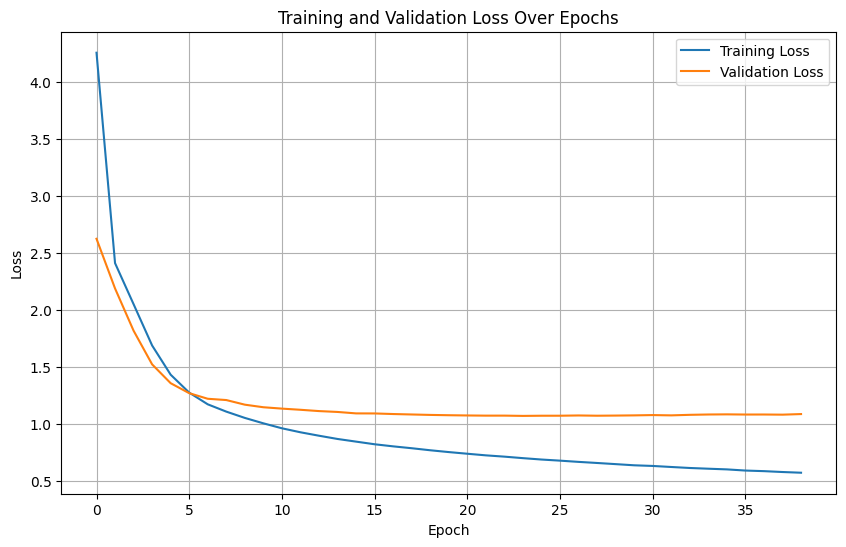

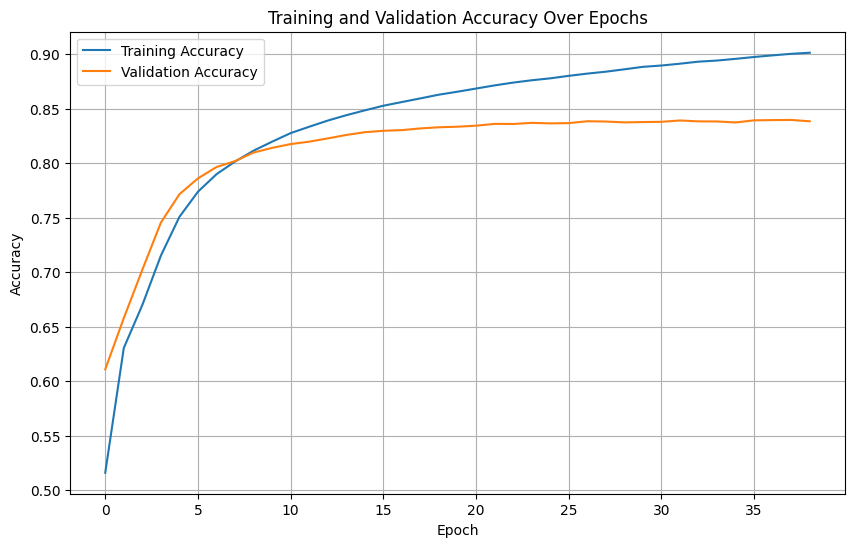

In [21]:
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot accuracy similarly
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
def translate(english_sentence, beam_width=3):
    """
    Translates an English sentence to Spanish using the trained Transformer model
    with beam search.
    """
    # Preprocess the input sentence
    tokenized_english = eng_sp.encode(english_sentence.lower())
    encoder_input = tf.constant([tokenized_english], dtype=tf.int64)

    # The decoder's input starts with the BOS token
    start_token = esp_sp.bos_id()
    end_token = esp_sp.eos_id()

    # Initialize the beam with a Python list of lists.
    initial_beam = [([start_token], 0.0)]
    
    completed_hypotheses = []

    for _ in range(config.MAX_LENGTH):
        new_beam = []
        for seq, score in initial_beam:
            if seq[-1] == end_token:
                completed_hypotheses.append((seq, score))
                continue

            decoder_input = tf.constant([seq], dtype=tf.int64)
            predictions = transformer([encoder_input, decoder_input], training=False)
            
            # Get the log probabilities of the next possible tokens
            last_token_probs = predictions[:, -1, :]
            log_probs = tf.math.log(last_token_probs)
            
            # Get the top k most likely next tokens
            top_k_log_probs, top_k_indices = tf.nn.top_k(log_probs, k=beam_width)

            for i in range(beam_width):
                new_token = top_k_indices[0, i]
                new_log_prob = top_k_log_probs[0, i].numpy()
                
                # FIX: Convert the new_token to a native Python integer using .item()
                new_seq = seq + [new_token.numpy().item()]
                new_score = score + new_log_prob
                
                new_beam.append((new_seq, new_score))

        # If all beams have ended in EOS, we can stop early
        if not new_beam:
            break

        # Sort all new possible hypotheses by their score and keep the top k
        initial_beam = sorted(new_beam, key=lambda x: x[1] / len(x[0]), reverse=True)[:beam_width]

    # Add any remaining hypotheses from the beam to the completed list
    completed_hypotheses.extend(initial_beam)

    # Find the best translation among the completed hypotheses
    if not completed_hypotheses:
        return ""
        
    best_hypothesis = sorted(completed_hypotheses, key=lambda x: x[1] / len(x[0]), reverse=True)[0]
    best_seq = best_hypothesis[0]
    
    # Decode the sequence of token IDs back to a text string
    predicted_sentence = esp_sp.decode(best_seq)
    
    return predicted_sentence

In [30]:
from nltk.translate.bleu_score import sentence_bleu

# Select a sample from your validation dataframe
sample_index = 89
english_sentence = valid_df.iloc[sample_index]['english']
reference_hindi = valid_df.iloc[sample_index]['spanish']

# Use the translate function to get the model's prediction
predicted_hindi = translate(english_sentence)


print(f"English Input:     {english_sentence}")
print(f"Reference Spanish:   {reference_hindi}")
print(f"Predicted Spanish:   {predicted_hindi}")
print("-" * 30)

# Calculate the BLEU score
reference = [reference_hindi.split()]
candidate = predicted_hindi.split()
score = sentence_bleu(reference, candidate)

print(f"BLEU score for this sentence: {score:.4f}")

English Input:     let me pay my share.
Reference Spanish:   permitime pagar mi parte.
Predicted Spanish:   déjame pagar mi parte de mi parte.
------------------------------
BLEU score for this sentence: 0.0000
